# Relationship of Academic Intensity and Physical Activity

## Data Preprocessing

I will implement preprocessing on the raw data collected from Apple Health.  
The objective is to clean and organize the data into a structured CSV format.   


In [2]:
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime

# Path to the XML file
xml_file_path = "/Users/erayakalin/Desktop/export.xml" #file path

# Define metrics
metrics_of_interest = {
    "HKQuantityTypeIdentifierStepCount": "Step Count",
    "HKQuantityTypeIdentifierActiveEnergyBurned": "Active Energy",
    "HKQuantityTypeIdentifierDistanceWalkingRunning": "Walking + Running Distance",
    "HKQuantityTypeIdentifierFlightsClimbed": "Flights Climbed"
}

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract relevant records
records = []
for record in root.findall('Record'):
    record_type = record.attrib.get('type')
    if record_type in metrics_of_interest:
        records.append({
            "Metric": metrics_of_interest[record_type],
            "Value": float(record.attrib.get('value', 0)),
            "StartDate": record.attrib.get('startDate'),
            "EndDate": record.attrib.get('endDate')
        })

# Convert to DataFrame
health_data_df = pd.DataFrame(records)

# Convert dates to pandas datetime for easier processing
health_data_df['StartDate'] = pd.to_datetime(health_data_df['StartDate'])
health_data_df['EndDate'] = pd.to_datetime(health_data_df['EndDate'])

# Extract the date for grouping
health_data_df['Date'] = health_data_df['StartDate'].dt.date

# Calculate daily totals for "Step Count" and daily averages for other metrics
daily_totals = health_data_df.groupby(['Date', 'Metric'])['Value'].sum().reset_index()

# Pivot the data for better structure
daily_totals_pivoted = daily_totals.pivot(index='Date', columns='Metric', values='Value').reset_index()

# Save the daily totals to a CSV file
daily_csv_file_path = "health_data_daily_averages.csv"
daily_totals_pivoted.to_csv(daily_csv_file_path, index=False)

# Define school periods
define_school_periods = [
    ("Preparatory School", "2022-09-25", "2023-01-10"),
    ("Freshman First Term", "2023-02-20", "2023-06-10"),
    ("Freshman Second Term", "2023-09-25", "2024-01-10"),
    ("Sophomore First Term", "2024-02-20", "2024-06-10"),
    ("Sophomore Second Term", "2024-09-25", "2025-01-02")
]

# Filter data for each period
filtered_data = []
for period, start, end in define_school_periods:
    start_date = datetime.strptime(start, "%Y-%m-%d").date()
    end_date = datetime.strptime(end, "%Y-%m-%d").date()
    
    period_data = daily_totals_pivoted[
        (daily_totals_pivoted['Date'] >= start_date) & 
        (daily_totals_pivoted['Date'] <= end_date)
    ].copy()
    period_data["School Period"] = period
    filtered_data.append((period, period_data))

# Combine all periods into a single DataFrame
organized_data = pd.concat([data for _, data in filtered_data], ignore_index=True)

# Save the organized data to a CSV file
organized_csv_file_path = "organized_health_data.csv"
organized_data.to_csv(organized_csv_file_path, index=False)

print(f"Organized data saved to {organized_csv_file_path}")

Organized data saved to organized_health_data.csv


## Data Analysis

### Hypothesis

I hypothesize that my step count decreases as academic workload increases.

**Null Hypothesis**: Academic intensity has no significant impact on my step count.

**Alternative Hypothesis**: Increased academic intensity leads to a reduction in step count.

**Method**: Pairwise two-sample t-tests.


In [3]:
import pandas as pd
from scipy.stats import ttest_ind

# Load the organized data
file_path = "organized_health_data.csv"  # Ensure the file path matches your setup
organized_data = pd.read_csv(file_path)

# Merge terms for Freshman and Sophomore years
organized_data['School Period'] = organized_data['School Period'].replace(
    {
        'Freshman First Term': 'Freshman Year',
        'Freshman Second Term': 'Freshman Year',
        'Sophomore First Term': 'Sophomore Year',
        'Sophomore Second Term': 'Sophomore Year'
    }
)

# Filter only Step Count data
step_count_data = organized_data[['Date', 'Step Count', 'School Period']].dropna()

# Group data by School Period
prep_steps = step_count_data[step_count_data['School Period'] == 'Preparatory School']['Step Count']
freshman_steps = step_count_data[step_count_data['School Period'] == 'Freshman Year']['Step Count']
sophomore_steps = step_count_data[step_count_data['School Period'] == 'Sophomore Year']['Step Count']

# Perform two-sample t-tests
prep_vs_freshman = ttest_ind(prep_steps, freshman_steps, equal_var=False)
freshman_vs_sophomore = ttest_ind(freshman_steps, sophomore_steps, equal_var=False)
prep_vs_sophomore = ttest_ind(prep_steps, sophomore_steps, equal_var=False)

# Display results
results = {
    "Preparatory vs Freshman": prep_vs_freshman.pvalue,
    "Freshman vs Sophomore": freshman_vs_sophomore.pvalue,
    "Preparatory vs Sophomore": prep_vs_sophomore.pvalue
}

results_df = pd.DataFrame(list(results.items()), columns=["Comparison", "P-value"])

# Display the results
print(results_df)


                 Comparison       P-value
0   Preparatory vs Freshman  7.688998e-10
1     Freshman vs Sophomore  4.034900e-01
2  Preparatory vs Sophomore  6.026974e-09


# Results

The analysis reveals the following:

- A **significant decline in step counts** was observed:
  - From **Preparatory School to Freshman Year** (*p-value < 0.001*).
  - From **Preparatory School to Sophomore Year** (*p-value < 0.001*).
  - These results indicate a sharp drop in physical activity with the transition to university.

- The **lack of significance** in step counts between:
  - **Freshman Year and Sophomore Year** (*p-value = 0.403*) suggests stabilization in activity levels after the initial decline.
  - This stabilization may be attributed to lifestyle adjustments or increased academic demands.


# Data Visualization 

I will use EDA techniques to visualize the data

In [4]:
import pandas as pd
from IPython.display import display

# Load the organized data from the CSV file
organized_data = pd.read_csv("organized_health_data.csv")

# Merge terms for Freshman and Sophomore years
organized_data['School Period'] = organized_data['School Period'].replace(
    {
        'Freshman First Term': 'Freshman Year',
        'Freshman Second Term': 'Freshman Year',
        'Sophomore First Term': 'Sophomore Year',
        'Sophomore Second Term': 'Sophomore Year'
    }
)

# Group by school period and calculate the mean for all metrics
average_metrics = organized_data.groupby('School Period').mean(numeric_only=True).reset_index()

# Rename columns for clarity
average_metrics.rename(
    columns={
        'Step Count': 'Average Daily Step Count',
        'Active Energy': 'Average Daily Active Energy',
        'Walking + Running Distance': 'Average Daily Walking + Running Distance',
        'Flights Climbed': 'Average Daily Flights Climbed',
    },
    inplace=True,
)

# Set proper order for school periods
school_period_order = ['Preparatory School', 'Freshman Year', 'Sophomore Year']
average_metrics['School Period'] = pd.Categorical(
    average_metrics['School Period'], categories=school_period_order, ordered=True
)

# Sort by the specified order
average_metrics = average_metrics.sort_values('School Period').reset_index(drop=True)

# Display the table
display(average_metrics)


,School Period,Average Daily Active Energy,Average Daily Flights Climbed,Average Daily Step Count,Average Daily Walking + Running Distance
0,Preparatory School,234.339570,12.075472,8899.009259,5.918995
1,Freshman Year,191.943242,9.480952,6353.497717,4.448721
2,Sophomore Year,209.428736,10.780952,6570.457547,4.650792


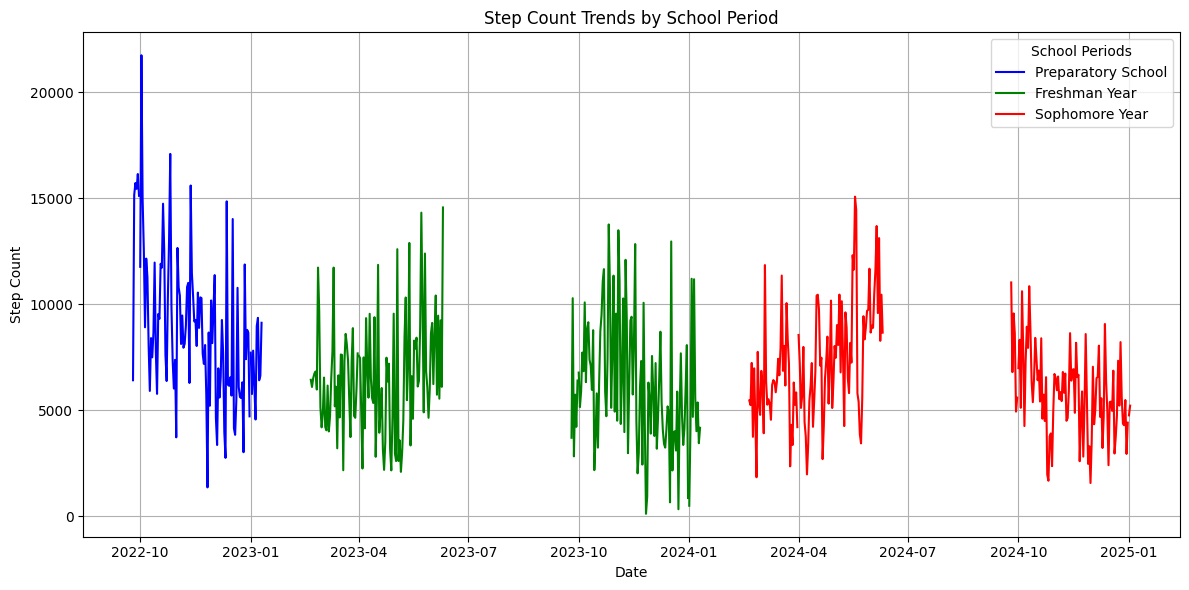

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the organized data from the CSV file
organized_data = pd.read_csv("organized_health_data.csv")

# Convert Date column to datetime format for plotting
organized_data['Date'] = pd.to_datetime(organized_data['Date'])

# Merge terms for Freshman and Sophomore years
organized_data['School Period'] = organized_data['School Period'].replace(
    {
        'Freshman First Term': 'Freshman Year',
        'Freshman Second Term': 'Freshman Year',
        'Sophomore First Term': 'Sophomore Year',
        'Sophomore Second Term': 'Sophomore Year'
    }
)

# Filter only Step Count data
step_count_data = organized_data[['Date', 'Step Count', 'School Period']].dropna()

# Define a color map for each school period
color_map = {
    'Preparatory School': 'blue',
    'Freshman Year': 'green',
    'Sophomore Year': 'red'
}

# Initialize the plot
plt.figure(figsize=(12, 6))

# Track whether we've added a label for each period
labels_added = set()

# Plot Step Count trends for each school period, segmenting by terms
for period in step_count_data['School Period'].unique():
    # Get data for each school period
    period_data = step_count_data[step_count_data['School Period'] == period]
    
    # Group data by contiguous date segments (e.g., quarterly)
    grouped = period_data.groupby(pd.Grouper(key='Date', freq='QS'))  # Quarterly start frequency
    for _, group in grouped:
        # Add label only once per school period
        label = period if period not in labels_added else None
        plt.plot(
            group['Date'], group['Step Count'], 
            label=label, color=color_map[period]
        )
        labels_added.add(period)

# Add titles and labels
plt.title("Step Count Trends by School Period")
plt.xlabel("Date")
plt.ylabel("Step Count")
plt.legend(title="School Periods")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


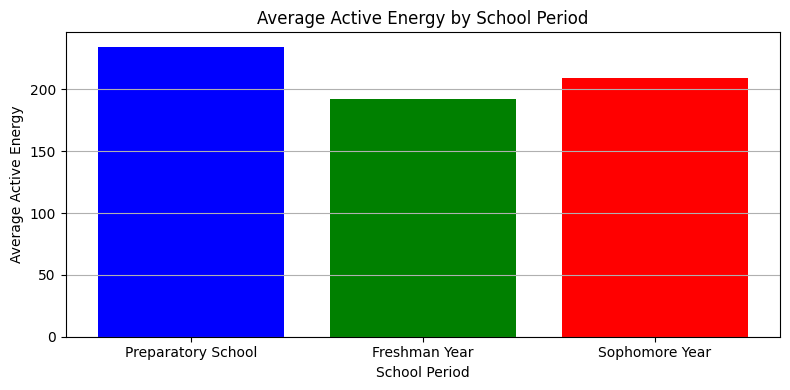

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by School Period and calculate average Active Energy
average_energy = organized_data.groupby('School Period')['Active Energy'].mean().reset_index()

# Set the proper order for school periods
school_period_order = ['Preparatory School', 'Freshman Year', 'Sophomore Year']
average_energy['School Period'] = pd.Categorical(
    average_energy['School Period'], categories=school_period_order, ordered=True
)

# Sort the data by the specified order
average_energy = average_energy.sort_values('School Period')

# Define a color map for each school period
color_map = {
    'Preparatory School': 'blue',
    'Freshman Year': 'green',
    'Sophomore Year': 'red'
}

# Create a bar chart
plt.figure(figsize=(8, 4))
plt.bar(
    average_energy['School Period'], 
    average_energy['Active Energy'], 
    color=[color_map[period] for period in average_energy['School Period']]
)

# Add titles and labels
plt.title("Average Active Energy by School Period")
plt.xlabel("School Period")
plt.ylabel("Average Active Energy")
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

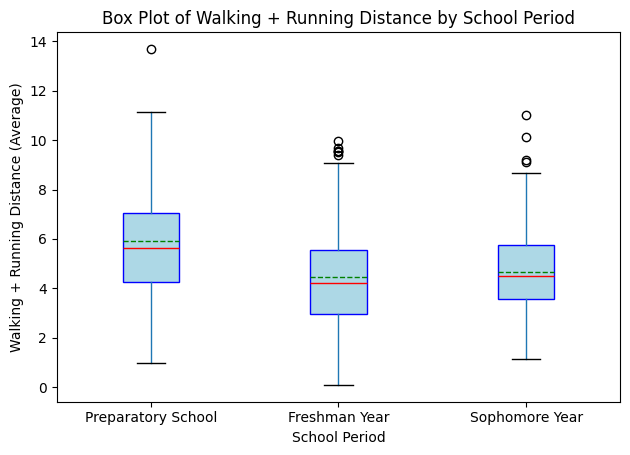

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter only Walking + Running Distance data
walking_running_data = organized_data[['School Period', 'Walking + Running Distance']].dropna()

# Set the proper order for school periods
school_period_order = ['Preparatory School', 'Freshman Year', 'Sophomore Year']
walking_running_data['School Period'] = pd.Categorical(
    walking_running_data['School Period'], categories=school_period_order, ordered=True
)

# Create a box plot
plt.figure(figsize=(10, 6))
walking_running_data.boxplot(
    by='School Period', 
    column='Walking + Running Distance', 
    grid=False, 
    showmeans=True, 
    meanline=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    meanprops=dict(color='green', linestyle='--')
)

# Add titles and labels
plt.title("Box Plot of Walking + Running Distance by School Period")
plt.suptitle("")  # Remove the automatic matplotlib subtitle
plt.xlabel("School Period")
plt.ylabel("Walking + Running Distance (Average)")
plt.tight_layout()

# Show the plot
plt.show()


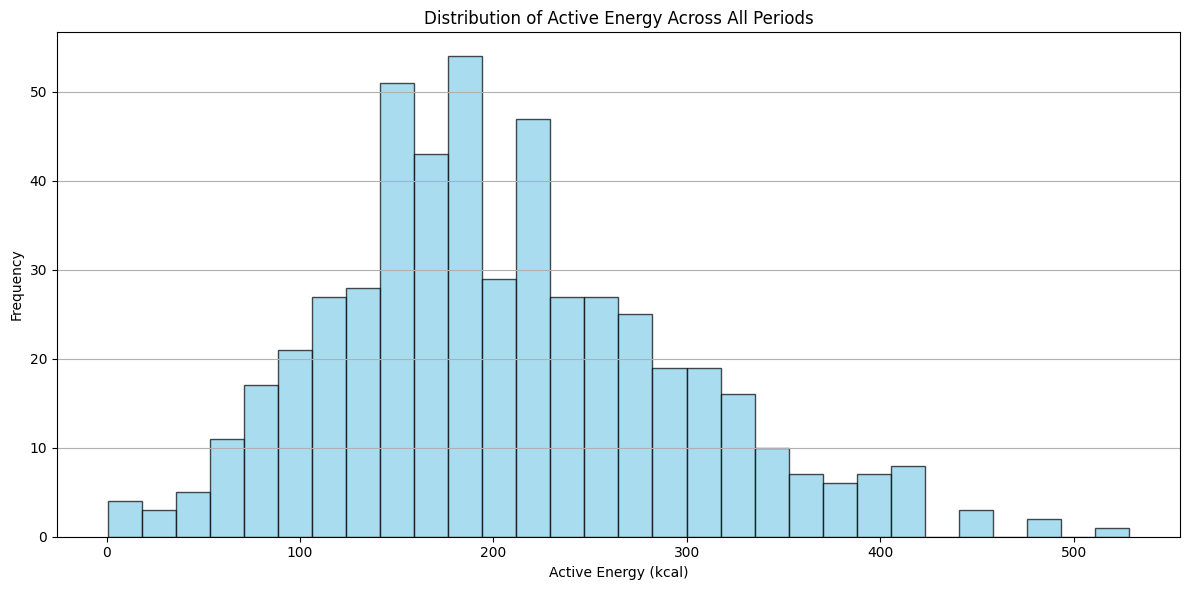

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter only Active Energy data
active_energy_data = organized_data[['School Period', 'Active Energy']].dropna()

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(
    active_energy_data['Active Energy'], 
    bins=30,  # Number of bins for the histogram
    color='skyblue', 
    edgecolor='black', 
    alpha=0.7
)

# Add titles and labels
plt.title("Distribution of Active Energy Across All Periods")
plt.xlabel("Active Energy (kcal)")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


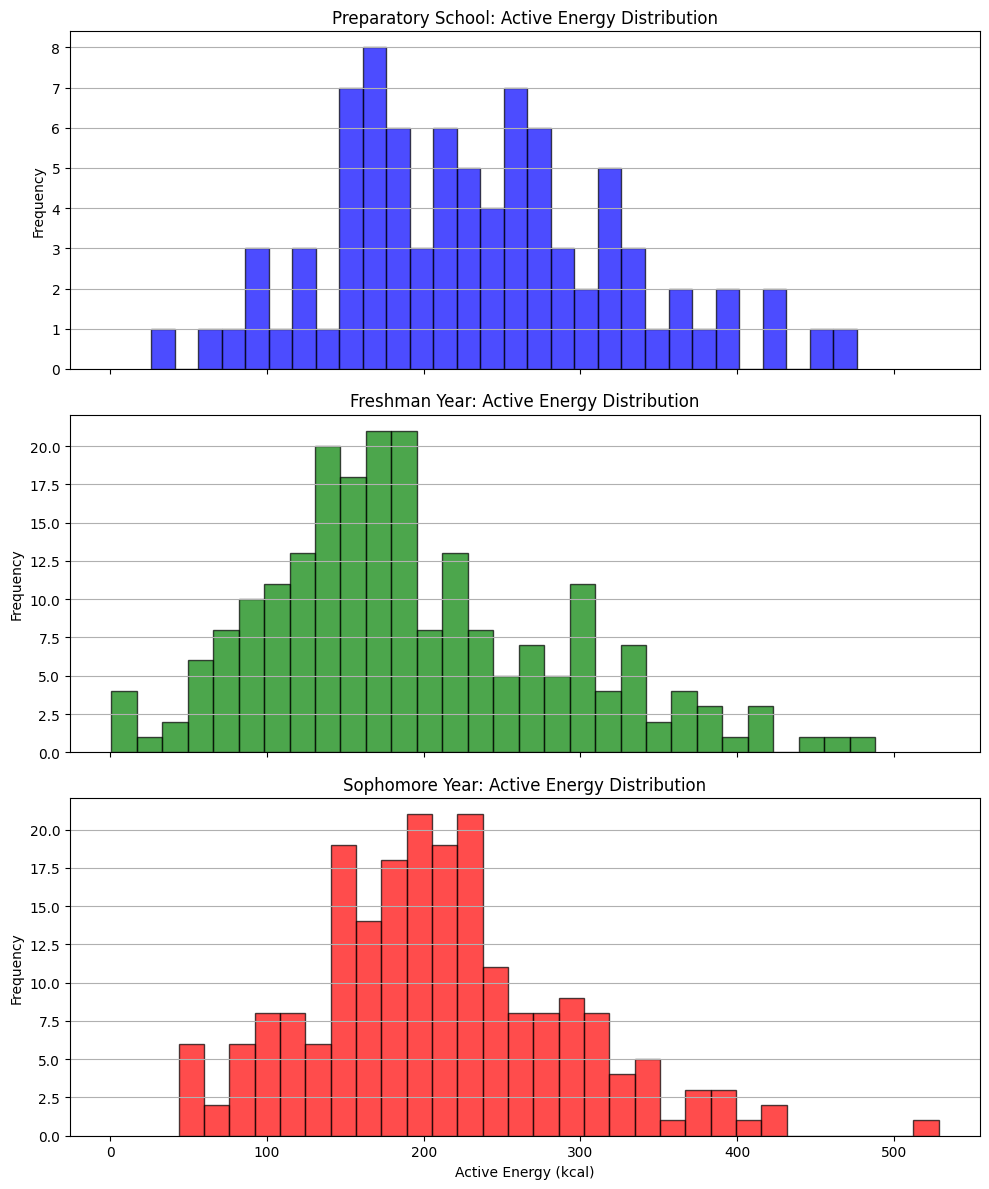

In [9]:
import matplotlib.pyplot as plt

# Define a color map for each school period
color_map = {
    'Preparatory School': 'blue',
    'Freshman Year': 'green',
    'Sophomore Year': 'red'
}

# Create subplots for each school period
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot histograms for each school period
for ax, (period, color) in zip(axes, color_map.items()):
    period_data = active_energy_data[active_energy_data['School Period'] == period]
    ax.hist(
        period_data['Active Energy'], 
        bins=30, 
        alpha=0.7,  # Reduced transparency for distinct colors
        color=color, 
        edgecolor='black'
    )
    ax.set_title(f"{period}: Active Energy Distribution")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y')

# Add common x-axis label
plt.xlabel("Active Energy (kcal)")
plt.tight_layout()

# Show the plot
plt.show()


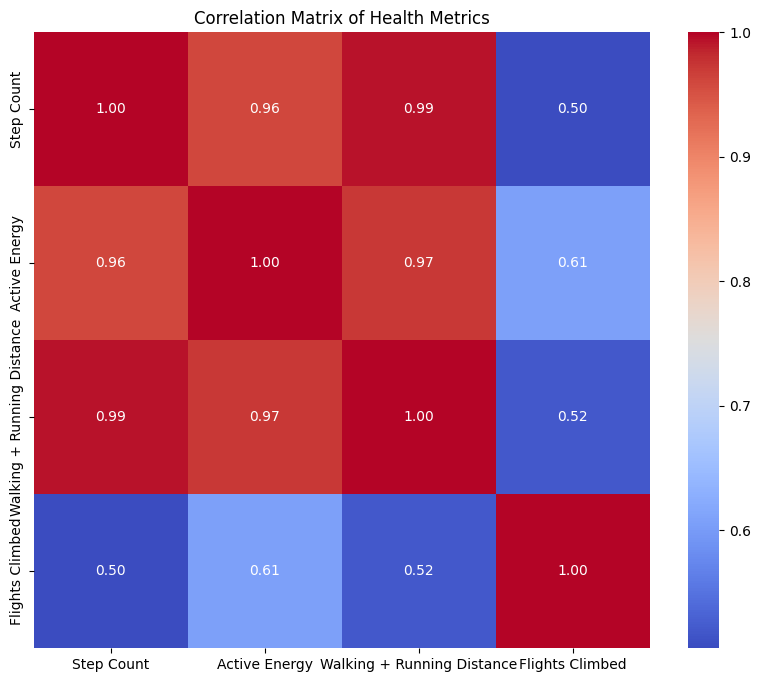

In [10]:
# Select numerical metrics for correlation analysis
metrics_data = organized_data[['Step Count', 'Active Energy', 'Walking + Running Distance', 'Flights Climbed']].dropna()

# Compute the correlation matrix
correlation_matrix = metrics_data.corr()

# Display the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True
)
plt.title("Correlation Matrix of Health Metrics")
plt.show()


### Step Count Analysis with Linear Regression 


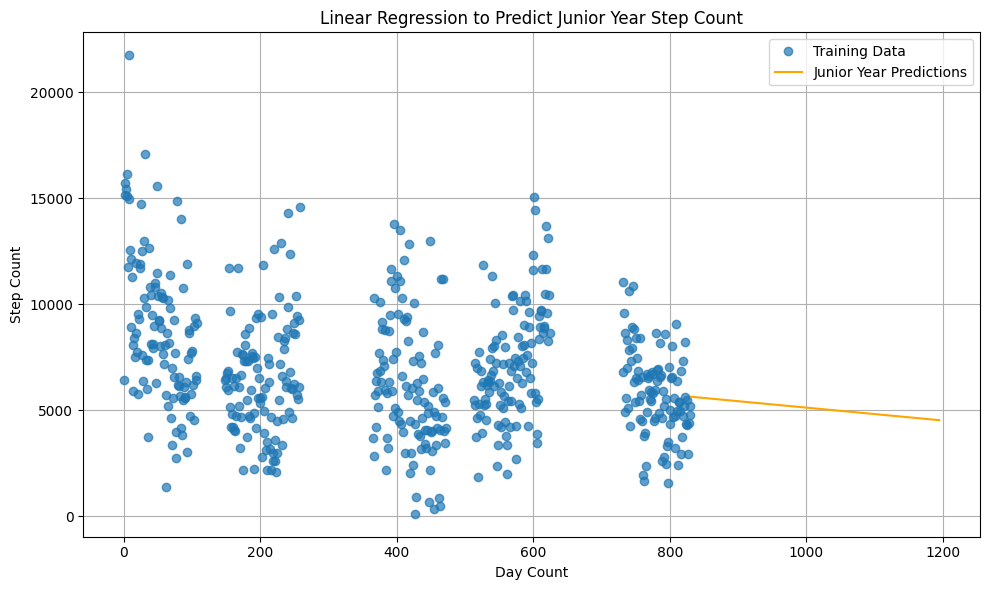

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure the Date column is in datetime format
organized_data['Date'] = pd.to_datetime(organized_data['Date'])

# Prepare the data
organized_data['Day Count'] = (organized_data['Date'] - organized_data['Date'].min()).dt.days
train_data = organized_data[organized_data['School Period'] != 'Junior Year']

# Select features and target variable
X = train_data[['Day Count']]
y = train_data['Step Count']

# Train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict for Junior Year
junior_start = organized_data['Date'].max() + pd.Timedelta(days=1)
junior_dates = pd.date_range(start=junior_start, periods=365)
junior_day_counts = (junior_dates - organized_data['Date'].min()).days
junior_predictions = model.predict(junior_day_counts.to_frame(index=False, name='Day Count'))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data['Day Count'], y, 'o', label='Training Data', alpha=0.7)
plt.plot(junior_day_counts, junior_predictions, '-', label='Junior Year Predictions', color='orange')
plt.xlabel("Day Count")
plt.ylabel("Step Count")
plt.title("Linear Regression to Predict Junior Year Step Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step Count Analysis and Prediction

The graph illustrates:

- **Actual Step Count Data**:
  - Data points from **Preparatory School**, **Freshman Year**, and **Sophomore Year** are shown as a scatter plot, representing training data.

- **Predicted Step Count Trend**:
  - The **orange line** represents the predicted trend for the **Junior Year**, based on a linear regression model.

### Key Insights:
- The linear regression model extrapolates a gradual trend from past data, indicating:
  - **Stable or slightly declining step count levels** in the Junior Year.
- This suggests that **physical activity**, as measured by step count, may remain consistent or slightly decrease in the absence of significant lifestyle changes.


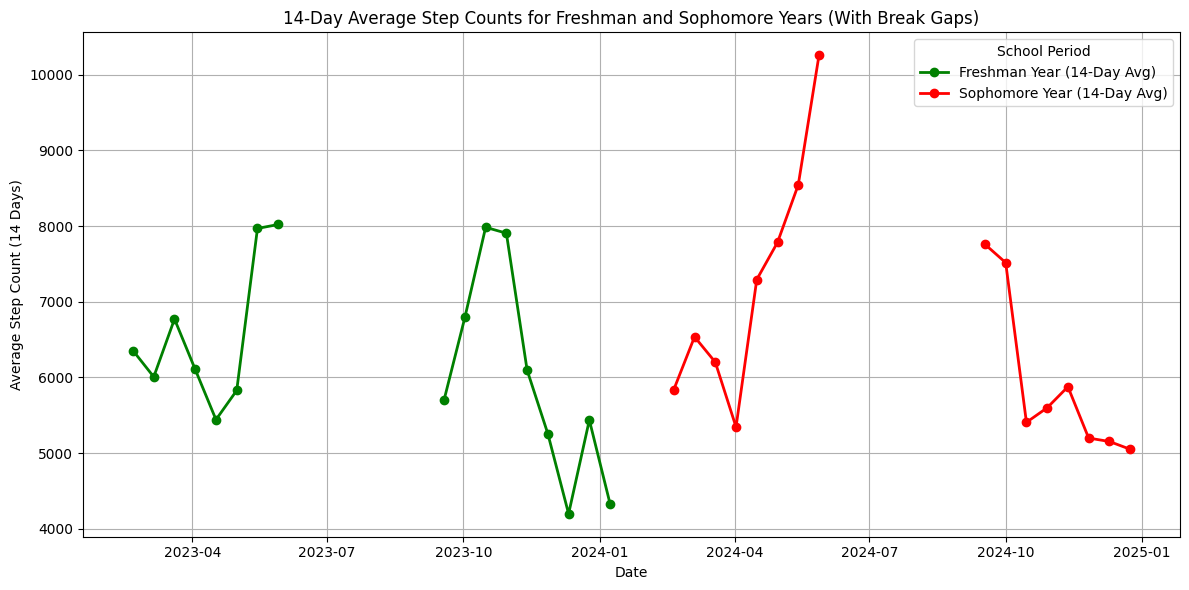

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the organized data from the CSV file
organized_data = pd.read_csv("organized_health_data.csv")

# Convert Date column to datetime format for plotting
organized_data['Date'] = pd.to_datetime(organized_data['Date'])

# Merge terms for Freshman and Sophomore years
organized_data['School Period'] = organized_data['School Period'].replace(
    {
        'Freshman First Term': 'Freshman Year',
        'Freshman Second Term': 'Freshman Year',
        'Sophomore First Term': 'Sophomore Year',
        'Sophomore Second Term': 'Sophomore Year'
    }
)

# Define all break periods (midterms and summer breaks) to exclude
break_periods = [
    ("2023-06-11", "2023-09-24"),  # Summer break for Freshman Year
    ("2024-06-11", "2024-09-24")   # Summer break for Sophomore Year
]

# Exclude break periods
for start, end in break_periods:
    organized_data = organized_data[~((organized_data['Date'] >= pd.to_datetime(start)) & (organized_data['Date'] <= pd.to_datetime(end)))]

# Filter data ONLY for Freshman and Sophomore years
step_count_data = organized_data[organized_data['School Period'].isin(['Freshman Year', 'Sophomore Year'])].copy()

# Define a color map for each school period
color_map = {
    'Freshman Year': 'green',
    'Sophomore Year': 'red'
}

# Initialize the plot
plt.figure(figsize=(12, 6))

# Plot Step Count trends for each school period using Grouper for 14-day aggregation
for period in step_count_data['School Period'].unique():
    # Filter data for the current period
    period_data = step_count_data[step_count_data['School Period'] == period]
    
    # Group by 14-day periods and calculate averages
    grouped_data = period_data.groupby(pd.Grouper(key='Date', freq='14D'))['Step Count'].mean().reset_index()

    # Plot the 14-day data
    plt.plot(
        grouped_data['Date'], 
        grouped_data['Step Count'], 
        label=f"{period} (14-Day Avg)", 
        color=color_map[period], 
        linewidth=2, 
        marker='o'
    )

# Add titles and labels
plt.title("14-Day Average Step Counts for Freshman and Sophomore Years (With Break Gaps)")
plt.xlabel("Date")
plt.ylabel("Average Step Count (14 Days)")
plt.legend(title="School Period")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


### Observations

- There is a **substantial drop in step count** at the end of the fall terms during both freshman and sophomore years.
- Conversely, there is a **substantial increase in step count** at the end of the spring terms during both freshman and sophomore years.


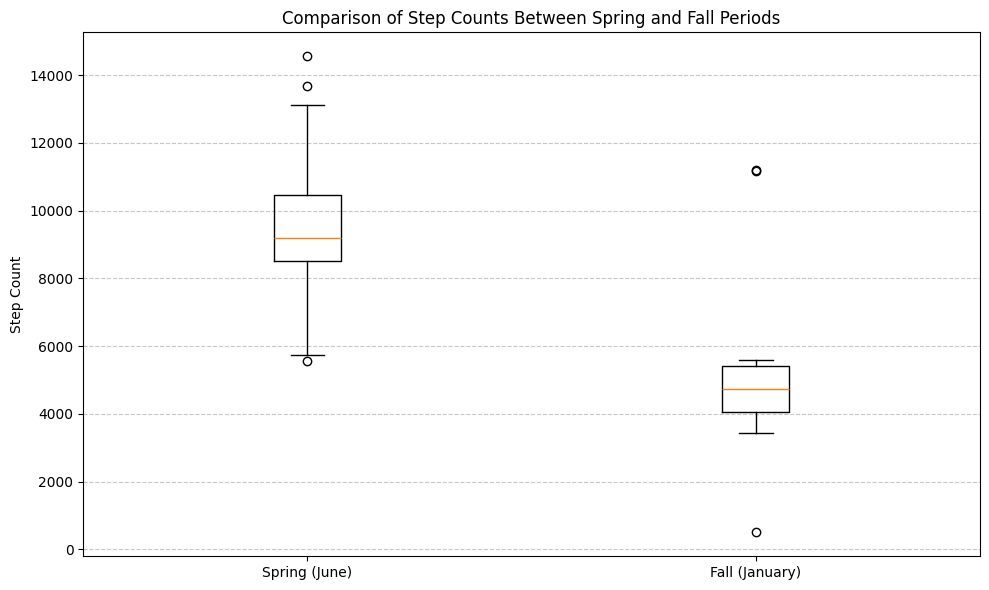

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the organized data from the CSV file
organized_data = pd.read_csv("organized_health_data.csv")

# Convert Date column to datetime format for plotting
organized_data['Date'] = pd.to_datetime(organized_data['Date'])

# Merge terms for Freshman and Sophomore years
organized_data['School Period'] = organized_data['School Period'].replace(
    {
        'Freshman First Term': 'Freshman Year',
        'Freshman Second Term': 'Freshman Year',
        'Sophomore First Term': 'Sophomore Year',
        'Sophomore Second Term': 'Sophomore Year'
    }
)

# Filter data for Spring (June) and Fall (January) periods
spring_data = organized_data.loc[
    (organized_data['Date'].dt.month == 6) & 
    (organized_data['School Period'].isin(['Freshman Year', 'Sophomore Year']))
].copy()

fall_data = organized_data.loc[
    (organized_data['Date'].dt.month == 1) & 
    (organized_data['School Period'].isin(['Freshman Year', 'Sophomore Year']))
].copy()

# Add a new column for period labels
spring_data['Period'] = 'Spring (June)'
fall_data['Period'] = 'Fall (January)'

# Combine both datasets
comparison_data = pd.concat([spring_data, fall_data])

# Create a boxplot for Step Count
plt.figure(figsize=(10, 6))
plt.boxplot(
    [comparison_data[comparison_data['Period'] == 'Spring (June)']['Step Count'],
     comparison_data[comparison_data['Period'] == 'Fall (January)']['Step Count']],
    tick_labels=['Spring (June)', 'Fall (January)']  # Updated to use tick_labels
)

# Add titles and labels
plt.title("Comparison of Step Counts Between Spring and Fall Periods")
plt.ylabel("Step Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Additional Insight

- These boxplots also suggest that **external factors like weather conditions** could influence physical activity, similar to how academic intensity affects it.